In [1]:
import numpy
import matplotlib.pyplot as plt
import math

# night sky test March 11 Matlab Cal
fc = [ 2676.58131,   2683.51694 ] # in pixels 
cc = [ 352.84399,   199.46077 ] # in pixels
kc = [ 0.23801,   6.40623,   -0.00699,   -0.00156,  0.00000 ]

# get parameters 
u_0 = cc[0]
v_0 = cc[1]
f = (fc[0] + fc[1]) / 2
k_1 = kc[0] / f**3
k_2 = kc[1] / f**5
p_1 = kc[2] / f**2
p_2 = kc[3] / f**2


height = 480 # height of the image sensor, pixels, (MT9V022)
width = 640 # width of the image sensor, pixels, (MT9V022)    

T = []
e = []

for current_row in range(height):
    for current_col in range(width):

        # coordinate of a pixel on the undistorted image, in pixels, U'V' frame  
        u_u = (current_col + 0.5) - u_0
        v_u = (current_row + 0.5) - v_0

        ## forware mapping to distorted coordinate ##
        r = math.sqrt( u_u**2 + v_u**2 )

        # raidial distortion 
        delta_u_r = u_u * (k_1 * r**2 + k_2 * r**4 )
        delta_v_r = v_u * (k_1 * r**2 + k_2 * r**4 )
        
        # tangentail distortion
        delta_u_t = 2*p_1*u_u*v_u + p_2*(r**2 + 2*u_u**2)
        delta_v_t = 2*p_2*u_u*v_u + p_1*(r**2 + 2*v_u**2)

        # get corresponding point on the distorted image under U'V' frame (in pixels)
        u_d = u_u + delta_u_r + delta_u_t
        v_d = v_u + delta_v_r + delta_v_t

        # get e 
        e_i_u = u_d - u_u
        e.append(e_i_u)
        e_i_v = v_d - v_u
        e.append(e_i_v)

        # get u_i and v_i 
        r_i = math.sqrt( u_d**2 + v_d**2 )
        u_i = numpy.array([ -u_d*r_i**2, -u_d*r_i**4, -2*u_d*v_d, -(r_i**2+2*u_d**2), u_u*r_i**4, u_u*u_d*r_i**2, u_u*v_d*r_i**2, u_u*r_i**2 ])
        T.append(u_i)
        v_i = numpy.array([ -v_d*r_i**2, -v_d*r_i**4, -(r_i**2+2*u_d**2), -2*u_d*v_d, v_u*r_i**4, v_u*u_d*r_i**2, v_u*v_d*r_i**2, v_u*r_i**2 ])
        T.append(v_i)


# apply least square 
T_t = numpy.transpose(T) 
p = numpy.linalg.inv( T_t @ T) @ T_t @ e

a_1 = p[0]
a_2 = p[1]
a_3 = p[2]
a_4 = p[3]
a_5 = p[4]
a_6 = p[5]
a_7 = p[6]
a_8 = p[7]

[ 4.72251629e-06 -1.47548083e-11  5.40718521e-10  3.15303463e-10
 -1.47546930e-11  1.26044011e-15 -2.20571693e-14  4.72252718e-06]


In [5]:
print(f'f = {f}')
print(f'u0 = {u_0}')
print(f'v0 = {v_0}')
print(f'distortion: {p}')

f = 2680.049125
u0 = 352.84399
v0 = 199.46077
distortion: [ 4.72251629e-06 -1.47548083e-11  5.40718521e-10  3.15303463e-10
 -1.47546930e-11  1.26044011e-15 -2.20571693e-14  4.72252718e-06]


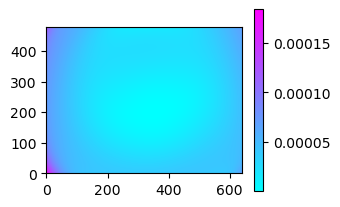

In [3]:
# verify error 
error_matrix = numpy.zeros(( height, width ))

for current_row in range(height):
    for current_col in range(width):

        # coordinate of a pixel on the distorted image, in pixels, U'V' frame  
        u_d = (current_col + 0.5) - u_0
        v_d = (current_row + 0.5) - v_0
        
        ## apply polynomial approximation ## 
        r = math.sqrt( u_d**2 + v_d**2 )
        G = (a_5*r**2 + a_6*u_d + a_7*v_d + a_8)*r**2 + 1
        u_u = (1/G) * ( u_d + u_d*(a_1*r**2 + a_2*r**4) + 2*a_3*u_d*v_d + a_4*(r**2+2*u_d**2) )
        v_u = (1/G) * ( v_d + v_d*(a_1*r**2 + a_2*r**4) + a_3*(r**2+2*v_d**2) + 2*a_4*u_d*v_d )

        ## forware mapping to map back to distorted coordinate ##
        r = math.sqrt( u_u**2 + v_u**2 )

        # raidial distortion 
        delta_u_r = u_u * (k_1 * r**2 + k_2 * r**4 )
        delta_v_r = v_u * (k_1 * r**2 + k_2 * r**4 )
        
        # tangentail distortion
        delta_u_t = 2*p_1*u_u*v_u + p_2*(r**2 + 2*u_u**2)
        delta_v_t = 2*p_2*u_u*v_u + p_1*(r**2 + 2*v_u**2)

        # get corresponding point on the distorted image under U'V' frame 
        u_d_e = u_u + delta_u_r + delta_u_t
        v_d_e = v_u + delta_v_r + delta_v_t
        
        # get residual error 
        error = math.sqrt( (u_d-u_d_e)**2 + (v_d-v_d_e)**2 )
        error_matrix[current_row, current_col] = error

plt.figure(num = 1, figsize = (3.1496063,2.36220472))  # 8cm and 6 cm
plt.imshow(error_matrix, cmap='cool', interpolation='none', origin='lower')
plt.colorbar()
plt.savefig('poly.png',dpi = 200, bbox_inches = 'tight') # high dpi, 'tight" to make sure complete pic
plt.show()
